In [1]:
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
def plot_all(train_df, s_times = 10, r_times=2, figsize = (18, 6)):

    figure, axis = plt.subplots(r_times, s_times, figsize=figsize)

    for r_id in range(r_times):
        for s_id in range(s_times):
            temp_df = train_df[(train_df['s_id']==s_id) &
                               (train_df['r_id']==r_id)]
            temp_df.plot(y=['train_loss', 'train_acc'], x='epoch', ax=axis[r_id, s_id])
            axis[r_id, s_id].set_title(f'r_id:{r_id}, s_id:{s_id}')
            #temp_df.plot(y=['train_loss'], x='epoch', ax=axis[r_id, s_id])
    plt.show()

def e_f_given_sr(prob_df, s_id, r_id, label =0):
    # E_{X,Y}[f(r,S,X,Y)]
    # E_{X}[f(r,S,X,y_i)] when label is given

    if label is not None:
        temp_df = prob_df[(prob_df['r_id'] == r_id) & (prob_df['s_id']==s_id) & (prob_df['label']==label)]
    else:
        temp_df =  prob_df[(prob_df['r_id'] == r_id) & (prob_df['s_id']==s_id)]
    e_f = temp_df['loss'].mean()
    return e_f

def e_f_given_r(prob_df, r_id, label = 0):
    s_ids = list(prob_df['s_id'].unique())
    e_f = []
    for s_id in s_ids:
        e_f.append(e_f_given_sr(prob_df, s_id, r_id, label))
    
    print(f'Exp_(s,x)[f(s,x,{label})] = ',np.mean(e_f))

    return np.mean(e_f)

def e_f(prob_df, label = 0):
    r_ids = list(prob_df['r_id'].unique())
    e_f = []
    for r_id in r_ids:
        e_f.append(e_f_given_r(prob_df, r_id, label))

    print(f'Exp_(r,s,x)[f(s,x,{label})] = ',np.mean(e_f))
    return e_f

def var_f_given_r(prob_df, r_id):
    # Var_{S}[ E_{X,Y}[ f(r,S,X,Y) ] ]
    s_ids = list(prob_df['s_id'].unique())
    f_op = []
    for s_id in s_ids:
        f_op.append(e_f_given_sr(prob_df, s_id, r_id, label=None))
    
    return np.var(f_op)

def var_f(prob_df):
    r_ids = list(prob_df['r_id'].unique())
    var_f_op = []
    for r_id in r_ids:
        var_f_op.append(var_f_given_r(prob_df, r_id))
    
    return var_f_op

def var_risk_given_r_by_m(prob_df, r_id, m_list = None):
    ## Var_{S}(E_{X,y}[f(r,S,X,Y)]) given r grouped by |S| = m
    if m_list is None:
        m_list = prob_df['m'].unique()
    e_f = []
    for m in m_list:
        e_f.append(var_f_given_r(prob_df[prob_df['m'] == m], r_id))

    return e_f

def var_risk_multiple_exp(prob_df):
    r_ids = list(prob_df['r_id'].unique())
    m_list = list(prob_df['m'].unique())
    var_exp_wise = []
    for r_id in r_ids:
        var_exp_wise.append(var_risk_given_r_by_m(prob_df, r_id, m_list))

    return var_exp_wise, m_list



### exp trial

In [10]:
train_file = 'results/exp_mnist_l16/train_file.csv'

train_df = pd.read_csv(train_file)
train_df

,r_id,s_id,epoch,train_loss,train_acc
0,0,0,0,0.692592,0.59
1,0,0,1,0.690297,0.59
2,0,0,2,0.690059,0.59
3,0,0,3,0.688338,0.59
4,0,0,4,0.686219,0.59
...,...,...,...,...,...
3995,1,9,195,0.344598,0.85
3996,1,9,196,0.346777,0.85
3997,1,9,197,0.342641,0.85
3998,1,9,198,0.361398,0.85


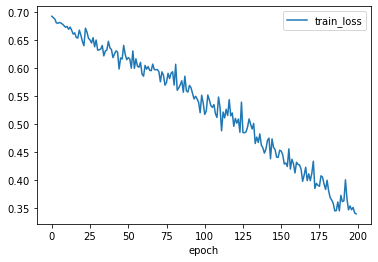

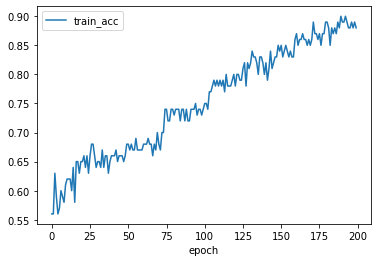

In [11]:
temp_df = train_df[(train_df['r_id'] == 1) & (train_df['s_id'] ==2)]

loss_list = temp_df.plot(y=['train_loss'], x='epoch')
plt.show()
loss_list = temp_df.plot(y=['train_acc'], x='epoch')


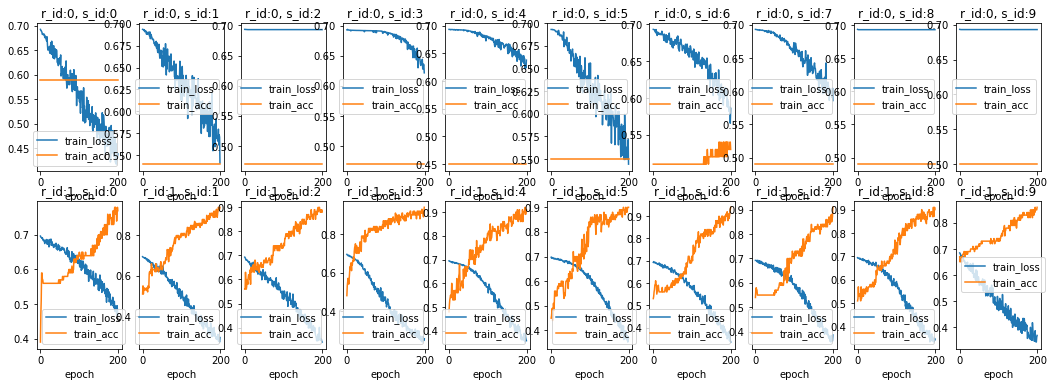

In [12]:

plot_all(train_df)

### exp_mnist_l32_e400_r5

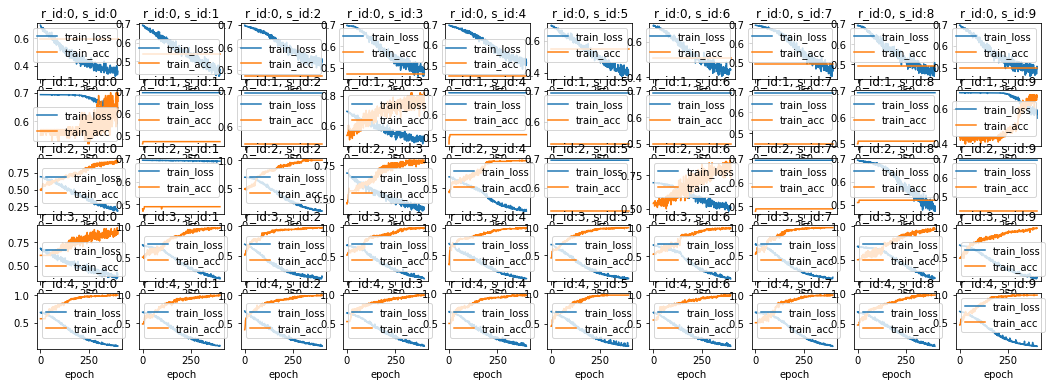

In [13]:
train_file = 'results/exp_mnist_lr32_e400_r5/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=10, r_times=5)

In [14]:
# problem prob
prob_file = 'results/exp_mnist_lr32_e400_r5/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=5)
prob_df

,r_id,s_id,z_id,loss,label
NaN,0,0,1397,7.672353,1
NaN,0,0,1397,0.693147,1
NaN,0,0,1397,0.100302,0
NaN,0,0,1397,0.987034,1
NaN,0,0,1397,3.294757,1
...,...,...,...,...,...
NaN,4,9,2642,1.156655,1
NaN,4,9,2642,0.375454,0
NaN,4,9,2642,0.570994,0
NaN,4,9,2642,3.136919,0


In [21]:
e_f(prob_df, label=0)

e_f(prob_df, label=1)


Exp_(s,x)[f(s,x,0)] =  0.3946807281671916
Exp_(s,x)[f(s,x,0)] =  0.8117735108149695
Exp_(s,x)[f(s,x,0)] =  0.9984904610391332
Exp_(s,x)[f(s,x,0)] =  1.168662728913032
Exp_(s,x)[f(s,x,0)] =  1.3163250653228438
Exp_(r,s,x)[f(s,x,0)] =  0.937986498851434
Exp_(s,x)[f(s,x,1)] =  1.5034680786530945
Exp_(s,x)[f(s,x,1)] =  0.6432408794141733
Exp_(s,x)[f(s,x,1)] =  0.9722567849447572
Exp_(s,x)[f(s,x,1)] =  1.322370025567539
Exp_(s,x)[f(s,x,1)] =  1.2375636462734934
Exp_(r,s,x)[f(s,x,1)] =  1.1357798829706112


### exp_mnist_l32_r20_s20_e500

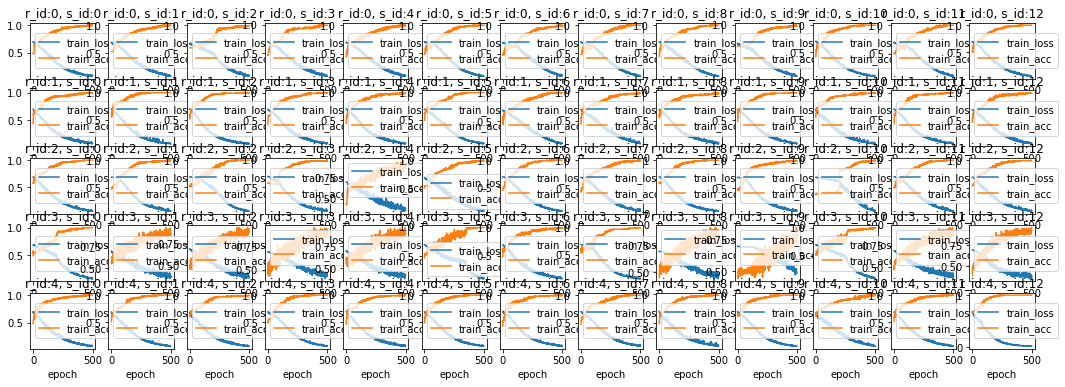

In [3]:
train_file = 'results/exp_mnist_l32_r20_s20_e500/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=13, r_times=5)

In [4]:
prob_file = 'results/exp_mnist_l32_r20_s20_e500/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=5)
prob_df

,r_id,s_id,z_id,loss,label
NaN,0,0,1915,0.001484,1
NaN,0,0,4362,0.025338,0
NaN,0,0,8398,1.143271,1
NaN,0,0,10472,0.045185,0
NaN,0,0,12587,5.432092,1
...,...,...,...,...,...
NaN,19,19,5302,0.693147,0
NaN,19,19,12628,0.386658,0
NaN,19,19,12657,0.693147,1
NaN,19,19,3518,1.802176,1


Exp_(s,x)[f(s,x,0)] =  1.5097819519170843
Exp_(s,x)[f(s,x,0)] =  1.2476424793624836
Exp_(s,x)[f(s,x,0)] =  1.4436701720622396
Exp_(s,x)[f(s,x,0)] =  1.7568882116019473
Exp_(s,x)[f(s,x,0)] =  1.5399407618526761
Exp_(s,x)[f(s,x,0)] =  1.661899158396612
Exp_(s,x)[f(s,x,0)] =  1.581285584418474
Exp_(s,x)[f(s,x,0)] =  1.389623411601808
Exp_(s,x)[f(s,x,0)] =  1.1121238319763036
Exp_(s,x)[f(s,x,0)] =  1.3690821721076083
Exp_(s,x)[f(s,x,0)] =  1.8643192122698065
Exp_(s,x)[f(s,x,0)] =  1.6702665256308786
Exp_(s,x)[f(s,x,0)] =  0.6589508728250728
Exp_(s,x)[f(s,x,0)] =  1.2025972459800902
Exp_(s,x)[f(s,x,0)] =  1.0566592324032573
Exp_(s,x)[f(s,x,0)] =  0.8067996714685298
Exp_(s,x)[f(s,x,0)] =  1.5419379536691213


Exp_(s,x)[f(s,x,0)] =  1.7325242103763834
Exp_(s,x)[f(s,x,0)] =  1.5871455811864332
Exp_(s,x)[f(s,x,0)] =  0.3703717181482408
Exp_(r,s,x)[f(s,x,0)] =  1.3551754979627524
Exp_(s,x)[f(s,x,1)] =  1.2472416176469756
Exp_(s,x)[f(s,x,1)] =  1.5530280627993516
Exp_(s,x)[f(s,x,1)] =  1.4093297178553659
Exp_(s,x)[f(s,x,1)] =  0.7324078498168318
Exp_(s,x)[f(s,x,1)] =  1.5944694028567632
Exp_(s,x)[f(s,x,1)] =  0.4159866280452557
Exp_(s,x)[f(s,x,1)] =  1.4198297118232215
Exp_(s,x)[f(s,x,1)] =  1.5936134852110162
Exp_(s,x)[f(s,x,1)] =  1.5117471927565669
Exp_(s,x)[f(s,x,1)] =  1.4916554180793082
Exp_(s,x)[f(s,x,1)] =  1.3604707996794458
Exp_(s,x)[f(s,x,1)] =  1.3963130756656954
Exp_(s,x)[f(s,x,1)] =  1.3300539070628061
Exp_(s,x)[f(s,x,1)] =  1.2884638974593081
Exp_(s,x)[f(s,x,1)] =  1.4324794464448367
Exp_(s,x)[f(s,x,1)] =  1.6140415002999071
Exp_(s,x)[f(s,x,1)] =  1.3177464710614768
Exp_(s,x)[f(s,x,1)] =  1.2517442336826705
Exp_(s,x)[f(s,x,1)] =  1.5582049118394616
Exp_(s,x)[f(s,x,1)] =  1.5995113

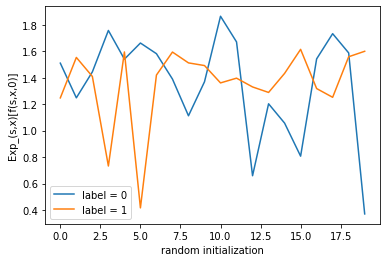

In [5]:
plt.plot(e_f(prob_df, label=0), label='label = 0')
plt.plot(e_f(prob_df, label=1), label='label = 1')
plt.ylabel('Exp_(s,x)[f(s,x,0)]')
plt.xlabel('random initialization')
plt.legend()


Text(0.5, 1.0, 'Var_S(f) for different randomness')

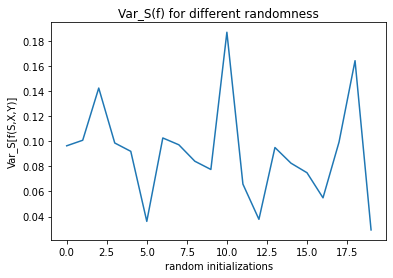

In [6]:
plt.plot(var_f(prob_df))
plt.ylabel('Var_S[f(S,X,Y)]')
plt.xlabel('random initializations')
plt.title('Var_S(f) for different randomness')

#### Plot for any given random initialization

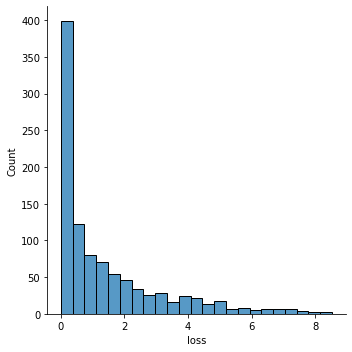

In [7]:
# plt.hist(prob_df[prob_df['r_id'] == 1]['loss'].to_list(), bins=50)

prob_df_indexed = prob_df.reset_index(drop=True)
sns.displot(prob_df_indexed[prob_df_indexed['r_id'] ==1], x='loss')#, hue='s_id', element='step')

#### Plot for all random initializations

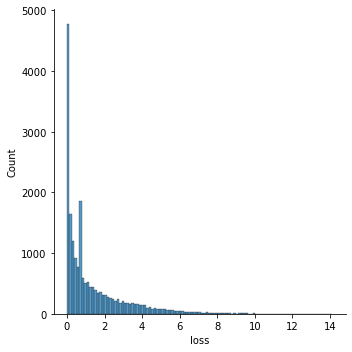

In [79]:
prob_df_indexed = prob_df.reset_index(drop=True)
sns.displot(prob_df_indexed, x='loss')#, hue='s_id', element='step')

### exp_gminst_l32_r50_s50_e500

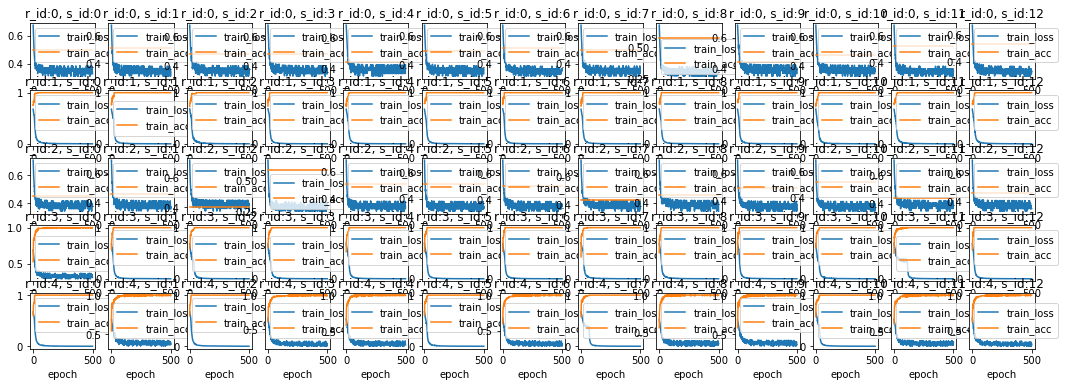

In [80]:
train_file = 'results/exp_gmnist_l32_r50_s50_e500/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=13, r_times=5)

In [84]:
prob_file = 'results/exp_gmnist_l32_r50_s50_e500/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)
prob_df

,r_id,s_id,z_id,loss,label
0,0,0,2711,0.000065,0
1,0,0,2482,0.693147,1
2,0,0,6905,0.000133,0
3,0,0,574,0.693147,1
4,0,0,1207,0.693147,1
...,...,...,...,...,...
9025,6,0,6768,0.693147,1
9026,6,0,4912,0.693147,0
9027,6,0,4055,0.693147,1
9028,6,0,7759,0.693147,1


Exp_(s,x)[f(s,x,0)] =  0.003534386681276137
Exp_(s,x)[f(s,x,0)] =  0.010051352889675493
Exp_(s,x)[f(s,x,0)] =  0.002968266606518307
Exp_(s,x)[f(s,x,0)] =  0.14006962702687406
Exp_(s,x)[f(s,x,0)] =  0.5915706240127961
Exp_(s,x)[f(s,x,0)] =  0.030161751273384555
Exp_(s,x)[f(s,x,0)] =  nan
Exp_(r,s,x)[f(s,x,0)] =  nan
Exp_(s,x)[f(s,x,1)] =  0.7300033824927609
Exp_(s,x)[f(s,x,1)] =  0.0066343421436809305
Exp_(s,x)[f(s,x,1)] =  0.7362901057495199
Exp_(s,x)[f(s,x,1)] =  0.004670530024570152
Exp_(s,x)[f(s,x,1)] =  0.0029727786718444647
Exp_(s,x)[f(s,x,1)] =  0.009193721707622058
Exp_(s,x)[f(s,x,1)] =  nan
Exp_(r,s,x)[f(s,x,1)] =  nan


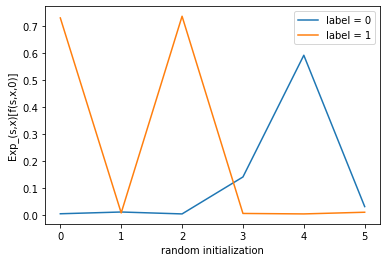

In [85]:
plt.plot(e_f(prob_df, label=0), label='label = 0')
plt.plot(e_f(prob_df, label=1), label='label = 1')
plt.ylabel('Exp_(s,x)[f(s,x,0)]')
plt.xlabel('random initialization')
plt.legend()

Text(0.5, 1.0, 'Var_S(f) for different randomness')

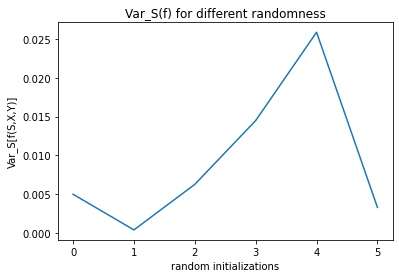

In [86]:
plt.plot(var_f(prob_df))
plt.ylabel('Var_S[f(S,X,Y)]')
plt.xlabel('random initializations')
plt.title('Var_S(f) for different randomness')

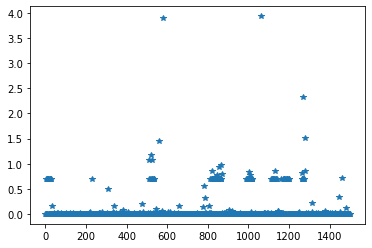

In [98]:
# sns.displot(prob_df[prob_df['r_id'] == 3]['loss'].to_list())
plt.plot(prob_df[prob_df['r_id'] == 3]['loss'].to_list(),'*' )

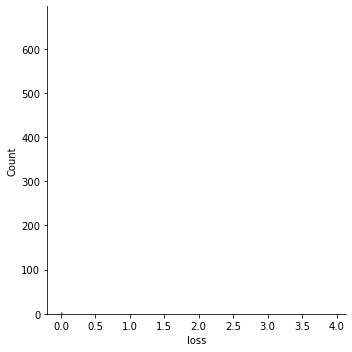

In [101]:
prob_df_indexed = prob_df
sns.displot(prob_df_indexed[prob_df_indexed['r_id'] ==3], x='loss')#, hue='s_id', element='step')

In [ ]:
prob_df_indexed = prob_df.reset_index(drop=True)
sns.displot(prob_df_indexed, x='loss')#, hue='s_id', element='step')

### exp_mnist_l32_8_r20_s20_e400

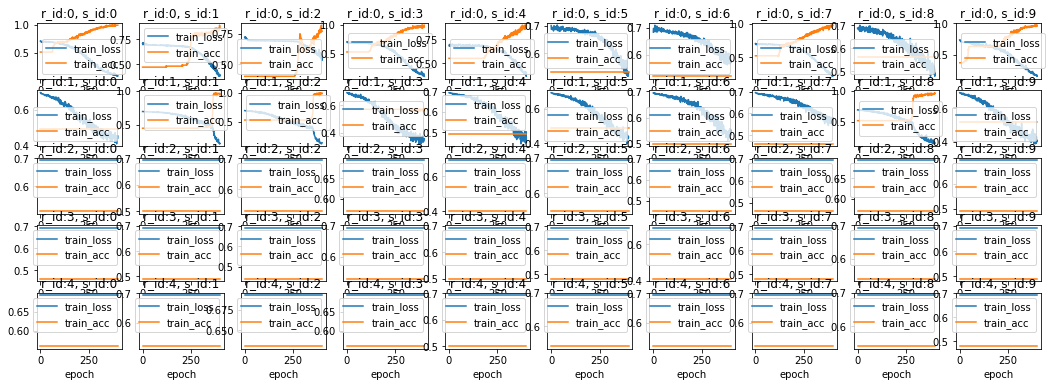

In [49]:
train_file = 'results/exp_mnist_l32_8_r20_s20_e400/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=10, r_times=5)

### exp_l32_r50_s50_e500_step_loss

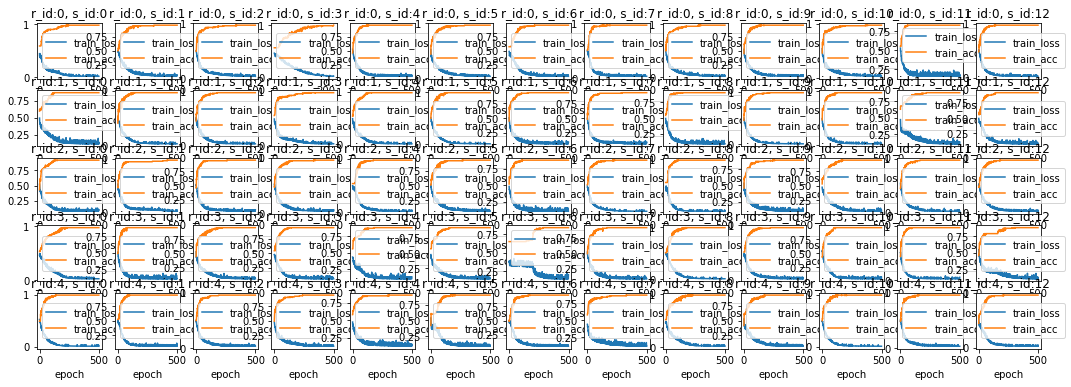

,r_id,s_id,epoch,train_loss,train_acc
0,0,0,0,0.446000,0.59
1,0,0,1,0.395101,0.59
2,0,0,2,0.442948,0.59
3,0,0,3,0.377608,0.59
4,0,0,4,0.392930,0.59
...,...,...,...,...,...
395,0,0,395,0.021833,0.98
396,0,0,396,0.048697,0.98
397,0,0,397,0.022118,0.98
398,0,0,398,0.023044,0.98


In [5]:
train_file = 'results/exp_mnist_l32_r50_s50_e500_step_loss/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=13, r_times=5)

,r_id,s_id,z_id,loss,label
0,0,0,4702,1.000000,1
1,0,0,7658,0.000005,1
2,0,0,12462,0.000516,0
3,0,0,6199,0.000008,1
4,0,0,9589,0.999859,1
...,...,...,...,...,...
74995,49,49,5521,0.000002,1
74996,49,49,10234,0.999971,0
74997,49,49,931,0.000000,1
74998,49,49,2269,0.044913,0


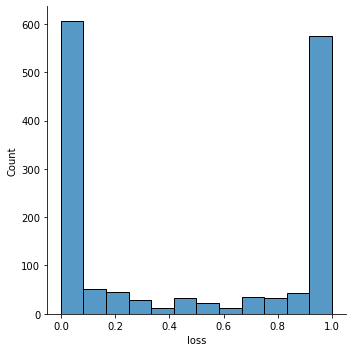

In [8]:
prob_file = 'results/exp_mnist_l32_r50_s50_e500_step_loss/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)

sns.displot(prob_df[prob_df['r_id'] ==3], x='loss')#, hue='s_id', element='step')
prob_df

In [7]:
# P_{S,X}[f(r,S,X,0) = M]

def prob_sx_given_r(prob_df, r_id, label =0, threshold= 0.5):

    temp_df = prob_df[(prob_df['r_id']==r_id) & (prob_df['label'] == label)]
    count = (temp_df['loss'] > threshold).sum()
    total = temp_df.shape[0]
    # print(f'count: {count}, total:{total}')
    return (1.0*count)/total

def get_alpha1(prob_df, r_ids, label= 0, threshold =0.9):

    up_bound = 0
    for r_id in r_ids:
        temp = prob_sx_given_r(prob_df, r_id, label=label, threshold=threshold)
        if temp > up_bound:
            up_bound =temp
    return up_bound

def get_alpha2(prob_df, r_ids, label= 0, threshold=0.9):

    lo_bound = prob_df.shape[0]
    for r_id in r_ids:
        temp = prob_sx_given_r(prob_df, r_id, label=label, threshold=threshold)
        if temp < lo_bound:
            lo_bound =temp
    return lo_bound

def get_alpha3(prob_df,r_ids, label =0):

    lo_bound = prob_df.shape[0]
    for r_id in r_ids:
        f_g_sr = []
        s_ids = prob_df[prob_df['r_id'] == r_id]['s_id'].unique()
        for s_id in s_ids:
            f_g_sr.append(e_f_given_sr(prob_df, s_id, r_id, label=label))
       
        ef_g_r = np.mean(f_g_sr)
        # print('ef_given_r', ef_g_r)
        if lo_bound > ef_g_r:
            lo_bound = ef_g_r
    return lo_bound

def var_bound(alpha_1, alpha_2, alpha_3, M, num_classes = 2):
    var_lb = (M*alpha_2)**2/num_classes + 2* alpha_3 - (M*alpha_1)**2
    # print('var_lb', var_lb)
    return var_lb

def show_multiple_var_bound(prob_df, exp_times = 7):
    all_r_ids = prob_df['r_id'].unique()
    r_ids_len = all_r_ids.shape[0]//exp_times
    print('len of r_ids',r_ids_len)

    r_ids_set = np.zeros((exp_times, r_ids_len), dtype=np.long)
    idx = 0
    for i in range(exp_times):
        
        for j in range(r_ids_len):
            # r_ids_set[i].append(all_r_ids[i*exp_times + j])
            r_ids_set[i][j] = int(all_r_ids[i*exp_times + j])
            idx+=1

    var_lb_list = []
    alpha_1_list = []
    alpha_2_list = []
    alpha_3_list = []
    for r_ids in r_ids_set:
        # print('r_ids',r_ids)
        alpha_1 = min(get_alpha1(prob_df,r_ids,label=0), get_alpha1(prob_df,r_ids,label=1))
        alpha_2 = min(get_alpha2(prob_df,r_ids,label=0), get_alpha2(prob_df,r_ids,label=1))
        alpha_3 = min(get_alpha3(prob_df,r_ids,label=0), get_alpha3(prob_df,r_ids,label=1))

        alpha_1_list.append(alpha_1)
        alpha_2_list.append(alpha_2)
        alpha_3_list.append(alpha_3)
        
        var_lb = var_bound(alpha_1, alpha_2, alpha_3,M=1, num_classes=2)
        var_lb_list.append(var_lb)
        # print('Var lb',var_lb)
    
    return var_lb_list, alpha_1_list, alpha_2_list, alpha_3_list

         

In [100]:
alpha_1 = get_alpha1(prob_df, [1,2,3,4,5,6], label=0, threshold=0.9)
print('alpha_1', alpha_1)
print()
alpha_2 = get_alpha2(prob_df, [1,2,3,4,5,6], label=0, threshold=0.9)
print('alpha_2', alpha_2)
alpha_3 = get_alpha3(prob_df, [1,2,3,4,5,6], label=0)
print('alpha_3', alpha_3)

type(alpha_1)

alpha_1 0.44339622641509435

alpha_2 0.3632596685082873
alpha_3 0.4670664757553775


numpy.float64

len of r_ids 7


/tmp/ipykernel_41378/716470972.py:54: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r_ids_set = np.zeros((exp_times, r_ids_len), dtype=np.long)


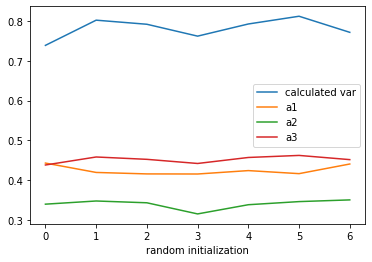

In [101]:
var_lb_list, a1_list, a2_list, a3_list = show_multiple_var_bound(prob_df, 7)

plt.plot(var_lb_list, label = 'calculated var')
plt.plot(a1_list, label = 'a1')
plt.plot(a2_list, label='a2')
plt.plot(a3_list, label = 'a3')
# plt.plot(np.zeros_like(var_lb_list))
plt.xlabel('random initialization')
plt.legend()
plt.show()

### ex2.1_mnist_l32_r50_s50_sloss

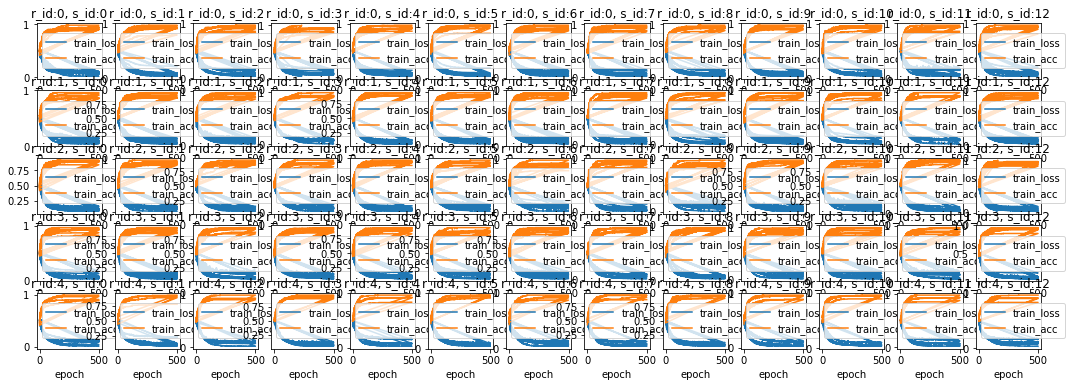

,r_id,s_id,epoch,train_loss,train_acc
0,0,0,0,0.446000,0.590
1,0,0,1,0.395101,0.590
2,0,0,2,0.442948,0.590
3,0,0,3,0.377608,0.590
4,0,0,4,0.392930,0.590
...,...,...,...,...,...
781575,4,20,413,0.072028,0.932
781576,4,20,414,0.072047,0.932
781577,4,20,415,0.074282,0.932
781578,4,20,416,0.069730,0.932


In [6]:
train_file = 'results/ex2.1_mnist_l32_r50_s50_sloss/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=13, r_times=5)
train_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,r_id,m,s_id,z_id,loss,label
0,0,100,0,0,1.000000,1
1,0,100,0,1,0.000005,1
2,0,100,0,2,0.000516,0
3,0,100,0,3,0.000008,1
4,0,100,0,4,0.999859,1
...,...,...,...,...,...,...
49075,4,300,35,25,0.001748,1
49076,4,300,35,26,0.999835,0
49077,4,300,35,27,0.993888,0
49078,4,300,35,28,0.000014,0


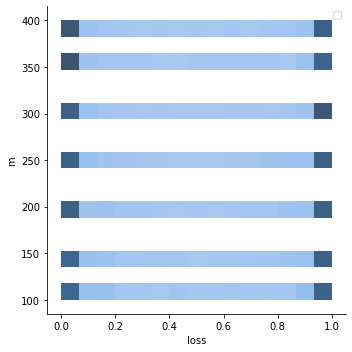

In [46]:
prob_file = 'results/ex2.1_mnist_l32_r50_s50_sloss/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)

sns.displot(prob_df[(prob_df['r_id'] ==3)], x='loss', y='m')#, hue='m', element='step')
plt.legend()
prob_df

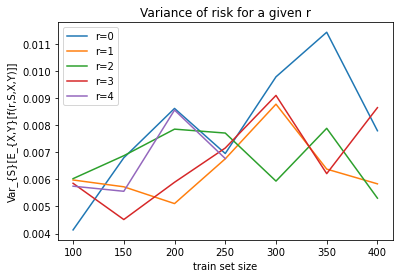

In [53]:
m_list = prob_df['m'].unique()
var_by_m = {}
r_ids = prob_df['r_id'].unique()
for r_id in r_ids:
    var_by_m[r_id] = var_risk_given_r_by_m(prob_df, r_id=r_id, m_list= m_list)
    plt.plot(m_list, var_by_m[r_id], label=f'r={r_id}')

plt.legend()
plt.xlabel('train set size')
plt.ylabel('Var_{S}[E_{X,Y}[f(r,S,X,Y)]]')
plt.title('Variance of risk for a given r')
# plt.savefig('results/ex2.1_mnist_l32_r50_s50_sloss/var_risk_given_r.png')
